# Optimizing Real World Problems

In this workshop we will code up a model called POM3 and optimize it using the GA we developed in the first workshop.

POM3 is a software estimation model like XOMO for Software Engineering. It is based on Turner
and Boehm’s model of agile development. It compares traditional plan-based approaches
to agile-based approaches in requirements prioritization. It describes how a team decides which
requirements to implement next. POM3 reveals requirements incrementally in random order, with
which developers plan their work assignments. These assignments are further adjusted based on
current cost and priority of requirement. POM3 is a realistic model which takes more runtime than
standard mathematical models(2-100ms, not 0.006-0.3ms)

In [8]:
%matplotlib inline
# All the imports
from __future__ import print_function, division
from math import *
import random
import sys
import matplotlib.pyplot as plt

# TODO 1: Enter your unity ID here 
__author__ = "rpotlur"

class O:
    """
    Basic Class which
        - Helps dynamic updates
        - Pretty Prints
    """
    def __init__(self, **kwargs):
        self.has().update(**kwargs)
    def has(self):
        return self.__dict__
    def update(self, **kwargs):
        self.has().update(kwargs)
        return self
    def __repr__(self):
        show = [':%s %s' % (k, self.has()[k]) 
                for k in sorted(self.has().keys()) 
                if k[0] is not "_"]
        txt = ' '.join(show)
        if len(txt) > 60:
            show = map(lambda x: '\t' + x + '\n', show)
        return '{' + ' '.join(show) + '}'
    
print("Unity ID: ", __author__)

Unity ID:  rpotlur


### The Generic Problem Class

Remember the Problem Class we coded up for GA workshop. Here we abstract it further such that it can be inherited by all the future classes. Go through these utility functions and classes before you proceed further.

In [9]:
# Few Utility functions
def say(*lst):
    """
    Print whithout going to new line
    """
    print(*lst, end="")
    sys.stdout.flush()

def random_value(low, high, decimals=2):
    """
    Generate a random number between low and high. 
    decimals incidicate number of decimal places
    """
    return round(random.uniform(low, high),decimals)

def gt(a, b): return a > b

def lt(a, b): return a < b

def shuffle(lst):
    """
    Shuffle a list
    """
    random.shuffle(lst)
    return lst

class Decision(O):
    """
    Class indicating Decision of a problem
    """
    def __init__(self, name, low, high):
        """
        @param name: Name of the decision
        @param low: minimum value
        @param high: maximum value
        """
        O.__init__(self, name=name, low=low, high=high)
        
class Objective(O):
    """
    Class indicating Objective of a problem
    """
    def __init__(self, name, do_minimize=True, low=0, high=1):
        """
        @param name: Name of the objective
        @param do_minimize: Flag indicating if objective has to be minimized or maximized
        """
        O.__init__(self, name=name, do_minimize=do_minimize, low=low, high=high)
        
    def normalize(self, val):
        return (val - self.low)/(self.high - self.low)

class Point(O):
    """
    Represents a member of the population
    """
    def __init__(self, decisions):
        O.__init__(self)
        self.decisions = decisions
        self.objectives = None
        
    def __hash__(self):
        return hash(tuple(self.decisions))
    
    def __eq__(self, other):
        return self.decisions == other.decisions
    
    def clone(self):
        new = Point(self.decisions[:])
        new.objectives = self.objectives[:]
        return new

class Problem(O):
    """
    Class representing the cone problem.
    """
    def __init__(self, decisions, objectives):
        """
        Initialize Problem.
        :param decisions -  Metadata for Decisions
        :param objectives - Metadata for Objectives
        """
        O.__init__(self)
        self.decisions = decisions
        self.objectives = objectives
        
    @staticmethod
    def evaluate(point):
        assert False
        return point.objectives
    
    @staticmethod
    def is_valid(point):
        return True
    
    def generate_one(self, retries = 20):
        for _ in xrange(retries):
            point = Point([random_value(d.low, d.high) for d in self.decisions])
            if self.is_valid(point):
                return point
        raise RuntimeError("Exceeded max runtimes of %d" % 20)

Great. Now that the class and its basic methods is defined, lets extend it for 
### POM3 model.

POM3 has multiple versions but for this workshop we will code up the POM3A model. It has 9 decisions defined as follows

* **Culture** in [0.1, 0.9]
* **Criticality** in [0.82, 1.20]
* **Criticality Modifier** in [2, 10]
* **Initially Known** in [0.4, 0.7]
* **Inter-Dependency** in [1, 100]
* **Dynamism** in [1, 50]
* **Size** in [0, 4]
* **Plan** in [0, 5]
* **Team Size** in [1, 44]

<img src="pom3.png"/>

The model has 4 objectives
* **Cost** in [0,10000] - Minimize
* **Score** in [0,1] - Maximize
* **Completion** in [0,1] - Maximize
* **Idle** in [0,1] - Minimize

In [10]:
class POM3(Problem):
    from pom3.pom3 import pom3 as  pom3_helper
    helper = pom3_helper()
    def __init__(self):
        """
        Initialize the POM3 classes
        """
        names = ["Culture", "Criticality", "Criticality Modifier", "Initial Known", 
                 "Inter-Dependency", "Dynamism", "Size", "Plan", "Team Size"]
        lows = [0.1, 0.82, 2, 0.40, 1, 1, 0, 0, 1]
        highs = [0.9, 1.20, 10, 0.70, 100, 50, 4, 5, 44]
        # TODO 2: Use names, lows and highs defined above to code up decision
        # and objective metadata for POM3.
#         decisions = [Decision(names[i], lows[i], highs[i])
#                      for i in xrange(len(Names))]
        decisions = [Decision(n, l, h) for n, l, h in zip(names, lows, highs)]
        objectives = [Objective("Cost", True, 0, 10000), Objective("Score", False, 0, 1),
                      Objective("Completion", False, 0, 1), Objective("Idle", True, 0, 1)]
        Problem.__init__(self, decisions, objectives)
        
    @staticmethod
    def evaluate(point):
        if not point.objectives:
            point.objectives = POM3.helper.simulate(point.decisions)
        return point.objectives
    
pom3 = POM3()
one = pom3.generate_one()
print(POM3.evaluate(one))

[217.50163353161707, 0.5117398035997244, 1.0, 0.37735849056603776]


### Utility functions for genetic algorithms.

In [11]:
def populate(problem, size):
    """
    Create a Point list of length size
    """
    population = []
    for _ in range(size):
        population.append(problem.generate_one())
    return population

def crossover(mom, dad):
    """
    Create a new point which contains decisions from 
    the first half of mom and second half of dad
    """
    n = len(mom.decisions)
    return Point(mom.decisions[:n//2] + dad.decisions[n//2:])

def mutate(problem, point, mutation_rate=0.01):
    """
    Iterate through all the decisions in the point
    and if the probability is less than mutation rate
    change the decision(randomly set it between its max and min).
    """
    for i, decision in enumerate(problem.decisions):
        if random.random() < mutation_rate:
            point.decisions[i] = random_value(decision.low, decision.high)
    return point

def bdom(problem, one, two):
    """
    Return if one dominates two based
    on binary domintation
    """
    objs_one = problem.evaluate(one)
    objs_two = problem.evaluate(two)
    dominates = False
    for i, obj in enumerate(problem.objectives):
        better = lt if obj.do_minimize else gt
        if better(objs_one[i], objs_two[i]):
            dominates = True
        elif objs_one[i] != objs_two[i]:
            return False
    return dominates

def fitness(problem, population, point, dom_func):
    """
    Evaluate fitness of a point based on the definition in the previous block.
    For example point dominates 5 members of population,
    then fitness of point is 5.
    """
    return len([1 for another in population if dom_func(problem, point, another)])

def elitism(problem, population, retain_size, dom_func):
    """
    Sort the population with respect to the fitness
    of the points and return the top 'retain_size' points of the population
    """
    fitnesses = []
    for point in population:
        fitnesses.append((fitness(problem, population, point, dom_func), point))
    population = [tup[1] for tup in sorted(fitnesses, reverse=True)]
    return population[:retain_size]
    

### Putting it all together and making the GA

In [12]:
def ga(pop_size = 100, gens = 250, dom_func=bdom):
    problem = POM3()
    population = populate(problem, pop_size)
    [problem.evaluate(point) for point in population]
    initial_population = [point.clone() for point in population]
    gen = 0 
    while gen < gens:
        say(".")
        children = []
        for _ in range(pop_size):
            mom = random.choice(population)
            dad = random.choice(population)
            while (mom == dad):
                dad = random.choice(population)
            child = mutate(problem, crossover(mom, dad))
            if problem.is_valid(child) and child not in population+children:
                children.append(child)
        population += children
        population = elitism(problem, population, pop_size, dom_func)
        gen += 1
    print("")
    return initial_population, population

### Visualize
Lets plot the initial population with respect to the final frontier.

In [13]:
def plot_pareto(initial, final):
    initial_objs = [point.objectives for point in initial]
    final_objs = [point.objectives for point in final]
    initial_x = [i[1] for i in initial_objs]
    initial_y = [i[2] for i in initial_objs]
    final_x = [i[1] for i in final_objs]
    final_y = [i[2] for i in final_objs]
    plt.scatter(initial_x, initial_y, color='b', marker='+', label='initial')
    plt.scatter(final_x, final_y, color='r', marker='o', label='final')
    plt.title("Scatter Plot between initial and final population of GA")
    plt.ylabel("Score")
    plt.xlabel("Completion")
    plt.legend(loc=9, bbox_to_anchor=(0.5, -0.175), ncol=2)
    plt.show()
    

..................................................


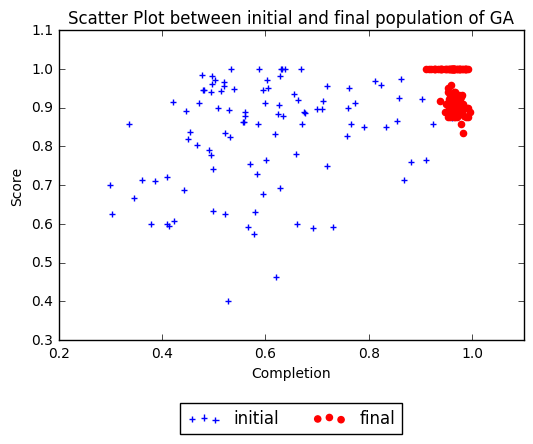

In [14]:
initial, final = ga(gens=50)
plot_pareto(initial, final)
# print(final)

### Sample Output
<img src="sample.png"/>